Some other useful references:<br>
    https://www.astroml.org/book_figures/chapter8/fig_outlier_rejection.html <br>
    https://github.com/rahulporuri/astro_data_projects/blob/af3c9f9c8c60d9812460c5b4ae3887f94488b1c0/mixture_models.ipynb <br>
    https://github.com/rahulporuri/astro_data_projects/blob/af3c9f9c8c60d9812460c5b4ae3887f94488b1c0/.ipynb_checkpoints/mixture_models-checkpoint.ipynb

In [1]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

import numpy as np
import matplotlib.pyplot as plt
import random
import os

#import multiprocessing
#from multiprocessing import Pool
#os.environ["OMP_NUM_THREADS"] = "1"

This notebook is based on the fitting a line to data from DFM: https://emcee.readthedocs.io/en/stable/tutorials/line/.
We will follow the same basic procedure, but include some number of outliers, and then attempt to model them following Hogg et al. 2010: https://arxiv.org/pdf/1008.4686.pdf <br>

One other difference is DFM's guide uses a fractional missing error (f), we are using an additive term, $\sigma_{sys}$.


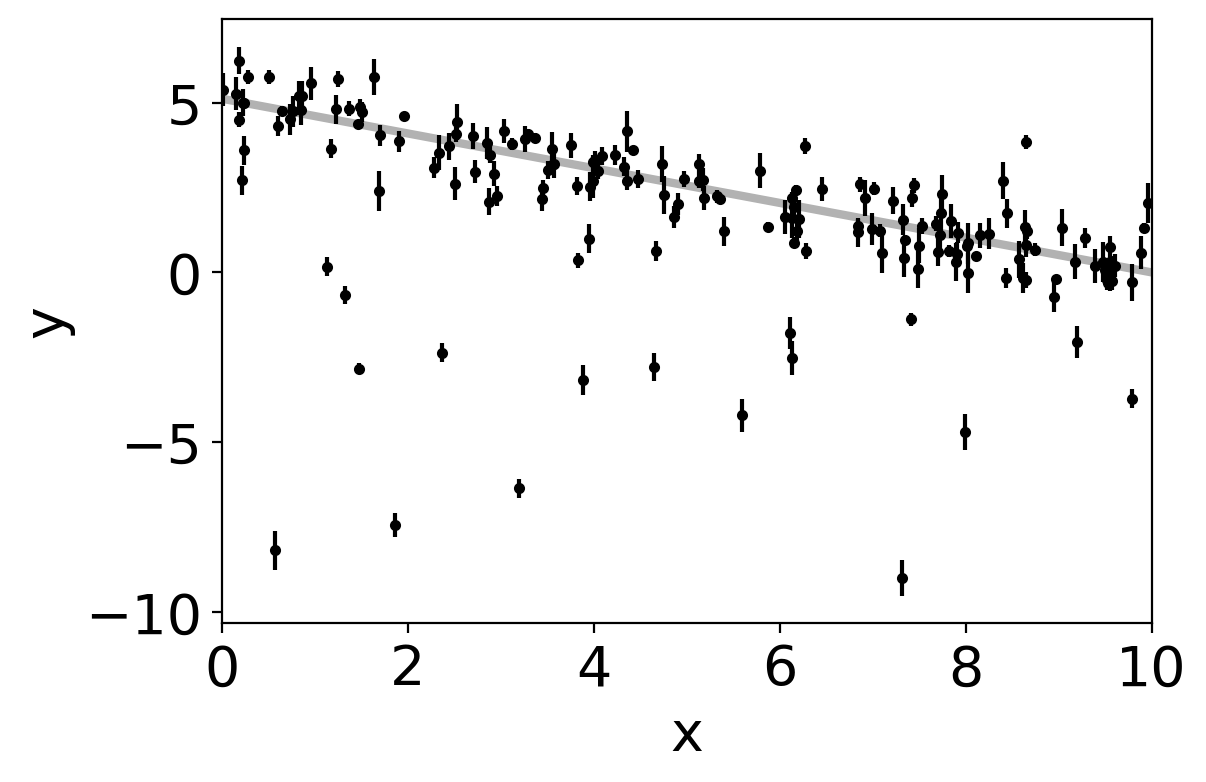

In [15]:
##np.random.seed(7) ## use this for reproducability
# Choose the "true" parameters.
m_true = -0.512
b_true = 5.123
sigsys_true = 0.6

## In practice, we won't know these variables.
## Note that things get a bit crazy when we make pb a large number (like >~0.3, but it depends on the parameters).
pb_true = 0.15 ## this is the fraction of points that are outliers. 
yb_true = -2 ## this is the mean of the outlier distribution
vb_true = 9 
## Vb is the variance of the outlier distribution, we can use log to force it to be positive, but I kept it linear
## for simplicity. 


# Generate some synthetic data from the model.
N = 150
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(sigsys_true) * np.random.randn(N)
y += yerr * np.random.randn(N)

## add in the outliers:
N_outliers = round(N/(1-pb_true)-N)
for i in range(N_outliers):
    y = np.append(y,random.gauss(yb_true, np.sqrt(vb_true))+0.1 + 0.5 * np.random.rand(1) + np.abs(sigsys_true)*np.random.randn(1))
    yerr = np.append(yerr,0.1 + 0.5 * np.random.rand(1))
    x = np.append(x,random.uniform(0,10))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

For SJ's sample should we use a uniform distribution to describe the outliers? 
I thought so at first, but I don't think it's truly uniform due to other selection criteria.
For example, slowpokes is only selecting stars in a specific range in terms of photometric distances. Meaning even non-members will be restricted in distance. Also stars are not uniformly distributed in distance even if selected randomly (more distant stars are more likely). I'm not convinced a Gaussian distribution is actually right either, but one can describe a lot of non-Gaussian distributions with really broad Gaussians. <br>

TL;DR: probably using a Gaussian is fine. 


Now let's do a simple Least-Squares estimate. The goal is to see that <b>this fit will be strongly biased </b> by the outliers:

Least-squares estimates:
m = -0.429 ± 0.007
b = 4.309 ± 0.039


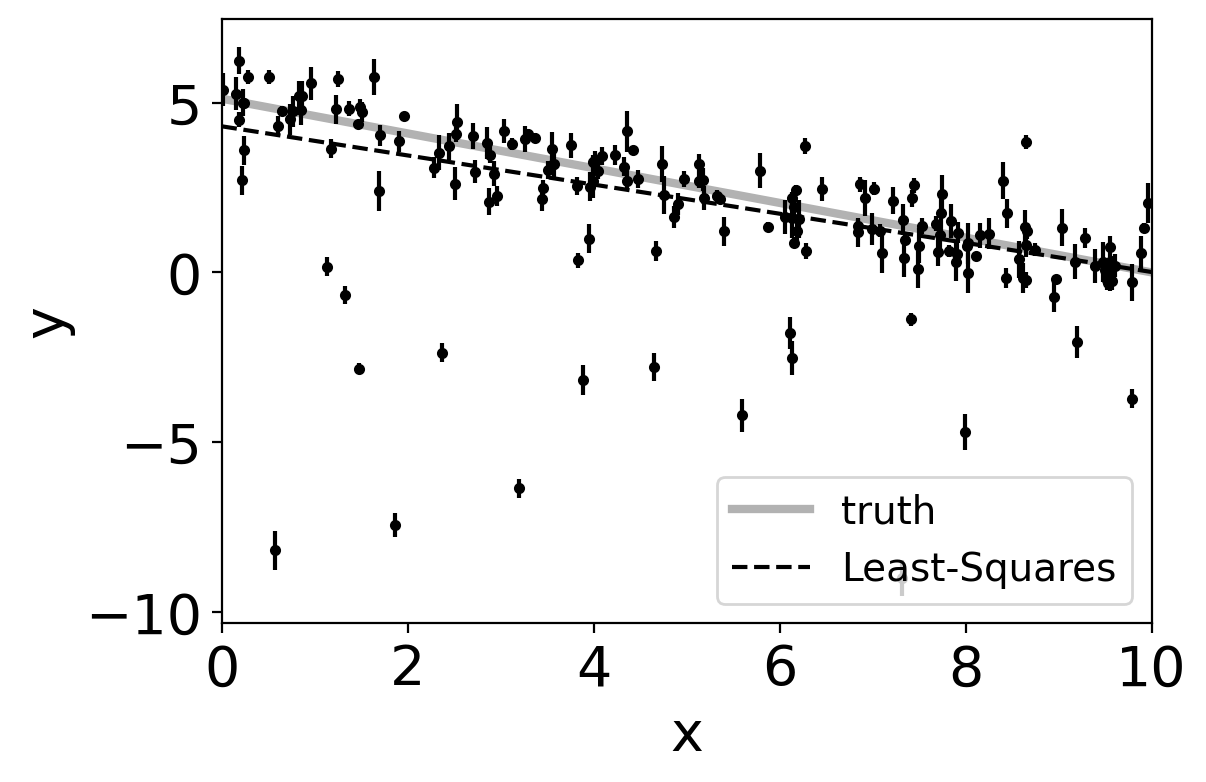

In [16]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="Least-Squares")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [17]:
## PRETTY SURE THIS IS WRONG! I was trying something, it didn't work. 

#def log_likelihood(theta, x, y, yerr):
#    m, b, log_f, pb, yb, vb = theta
#    model = m * x + b
#    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
#    vb2 = vb**2
#    A = -0.5 * np.sum(np.log(1.-pb)*((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2)))
#    B = -0.5 * np.sum(np.log(pb)*((y - yb) ** 2 / (vb2+sigma2)) + np.log(2*np.pi*(vb2+sigma2)))
#    if pb > 1 or pb < 0 or ~np.isfinite(A) or ~np.isfinite(B):
#        return -np.inf
#    #print(A,B)
#    return A+B
#def log_prior(theta):
#    m, b, log_f, pb, yb, vb = theta
#    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0 and pb >0 and pb <=0.95 and vb > 0:
#        return 0.0
#    return -np.inf
#def log_probability(theta, x, y, yerr):
#    lp = log_prior(theta)
#    if not np.isfinite(lp):
#        return -np.inf
#    return lp + log_likelihood(theta, x, y, yerr)

OK, now let's try this using a maximum likelihood. 
We won't use a prior for this step, but let's code it up now. 

In [18]:
## This is a uniform prior, but with some hard walls. Clearly 0<Pb<1 and sigsys>0, the rest are just 
## very generous limits to prevent something crazy happening. 
def ln_prior(theta):
    m, b, sigsys, Pb, Yb, Vb = theta
    # Vb is a variance, so it should be positive, that's why the logVb
    if -10 < m < 10 and -100 < b < 500 and 0 < Pb < 1 and -100 < Yb < 100 and 0 < Vb < 100 and sigsys>0:
        return 0
    return -np.inf

def ln_likelihood(theta, x, y, yerr):
    m, b, sigsys, Pb, Yb, Vb = theta
    model = m * x + b
    sigma2 = yerr ** 2 + sigsys**2
    p_fg = ((1-Pb) / np.sqrt(2 * np.pi * sigma2)) * np.exp(-(y-model)**2/(2 * sigma2))
    p_bg = (Pb / np.sqrt(2 * np.pi * (Vb + sigma2))) * np.exp(-(y - Yb)**2/(2 * (Vb + sigma2)))
    output = np.sum(np.log(p_fg + p_bg))
    return output

def ln_posterior(theta, x, y, yerr):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    return ln_p + ln_likelihood(theta, x, y, yerr)

Maximum likelihood estimates:
m = -0.521
b = 5.156
sig = 0.575
pb = 0.160
yb = -1.496
vb = 11.571
True values:
m = -0.512
b = 5.123
sig = 0.600
pb = 0.150
yb = -2.000
vb = 9.000


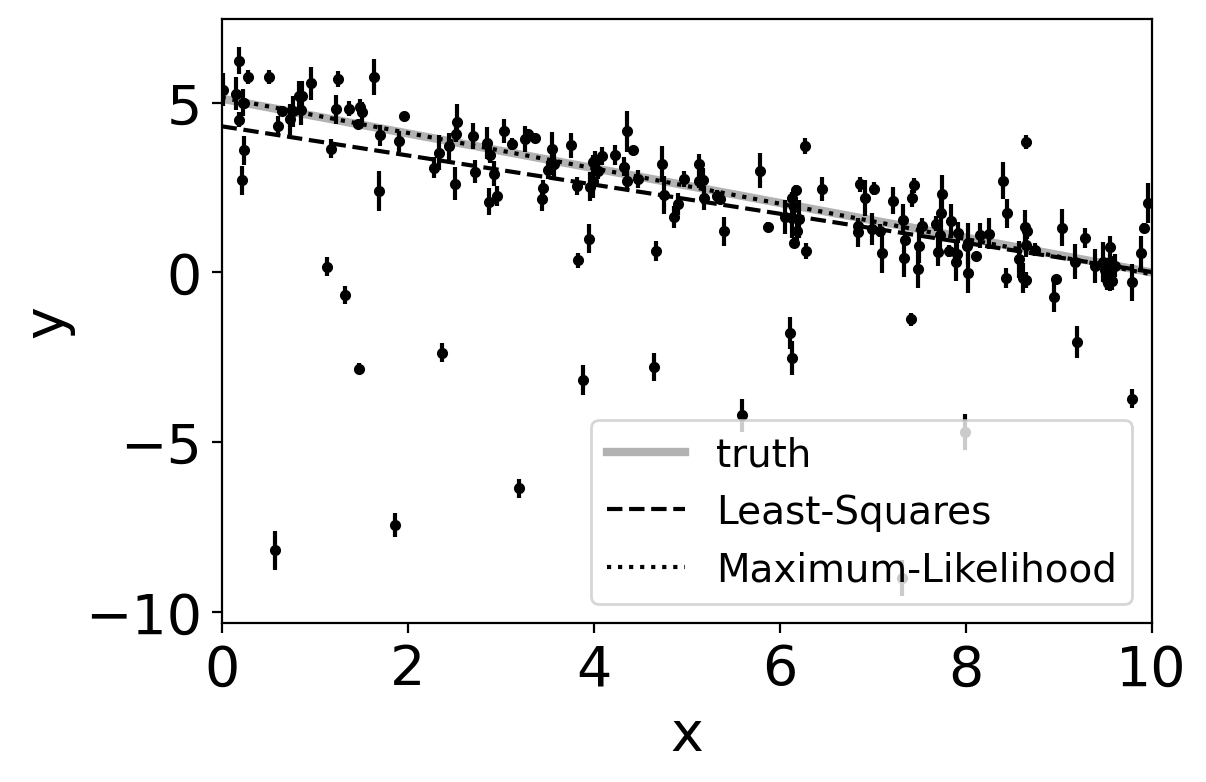

In [19]:
from scipy.optimize import minimize

np.random.seed(2)
nll = lambda *args: -ln_posterior(*args)
initial = np.array([m_true, b_true, sigsys_true, pb_true, yb_true, vb_true]) + 0.4 * np.random.randn(6)
initial[3] = np.abs(initial[3])
initial[2] = np.abs(initial[2])
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, sig_ml, pb, yb, vb = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("sig = {0:.3f}".format(sig_ml))
print("pb = {0:.3f}".format(pb))
print("yb = {0:.3f}".format(yb))
print("vb = {0:.3f}".format(vb))

print("True values:")
print("m = {0:.3f}".format(m_true))
print("b = {0:.3f}".format(b_true))
print("sig = {0:.3f}".format(sigsys_true))
print("pb = {0:.3f}".format(pb_true))
print("yb = {0:.3f}".format(yb_true))
print("vb = {0:.3f}".format(vb_true))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="Least-Squares")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="Maximum-Likelihood")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Maximum likelihood is doing reasonably well. But let's do this as full MCMC:

In [20]:
import emcee
np.random.seed(6346)
theta_0 = soln.x
ndim, nwalkers = 6, 64
pos_0 = [theta_0 + 0.01*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, 
                                args=(x, y, yerr), threads=8)
## run a shorter run for burn-in
state = sampler.run_mcmc(pos_0, 1000);
sampler.reset()
sampler.run_mcmc(state, 10000, progress=True);

100%|██████████| 10000/10000 [00:36<00:00, 275.64it/s]


A good check is to see how the walkers behave, should look just like noise after the burn-in

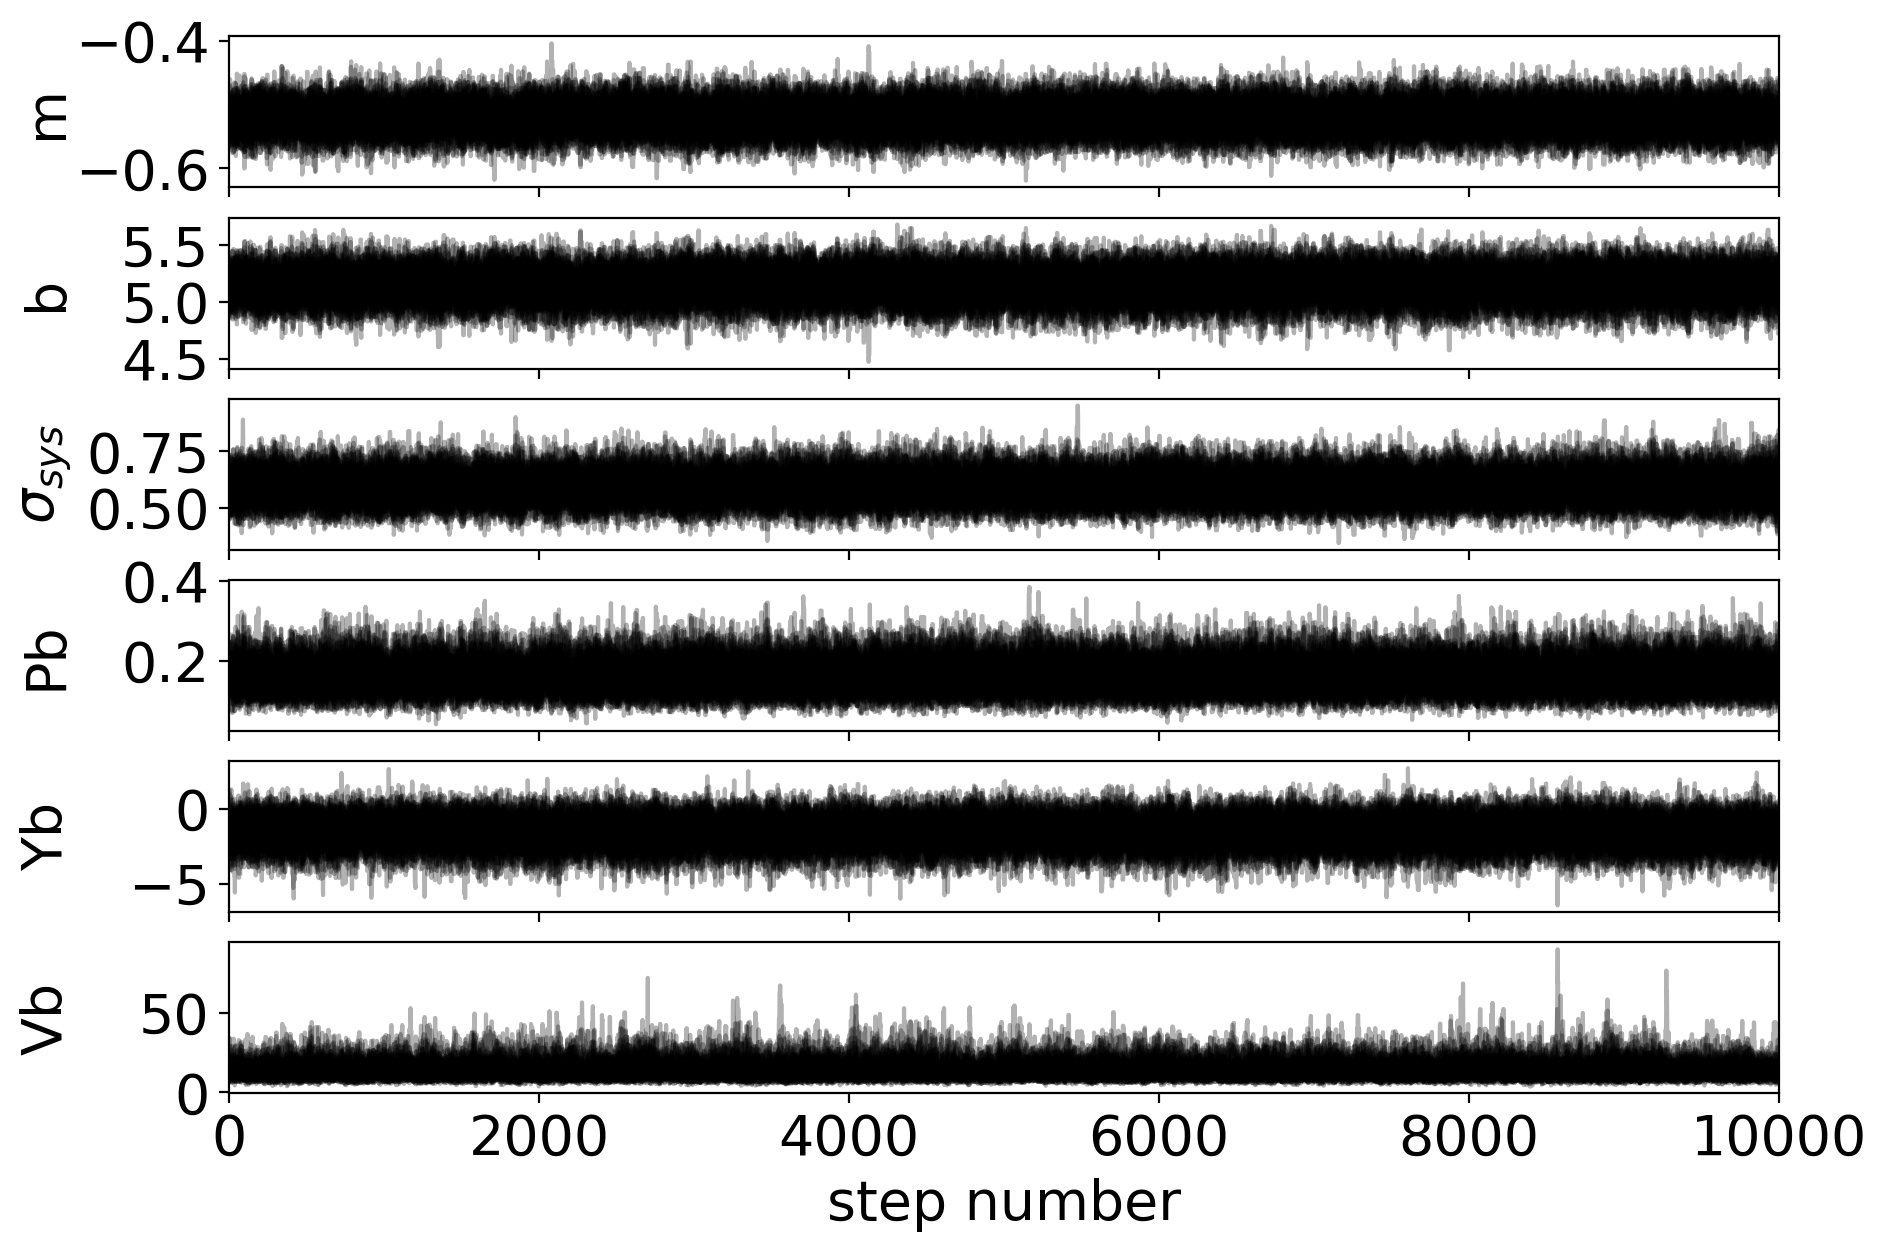

In [21]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "$\sigma_{sys}$",'Pb','Yb','Vb']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [22]:
## check the autocorrelation time (this is to check for convergence)
tau = sampler.get_autocorr_time()
print(tau)

[70.74152801 70.64882601 67.32847625 65.52378237 67.11622263 68.6757094 ]


In [23]:
## flatten (i.e., dump the separate walkers)
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(42240, 6)


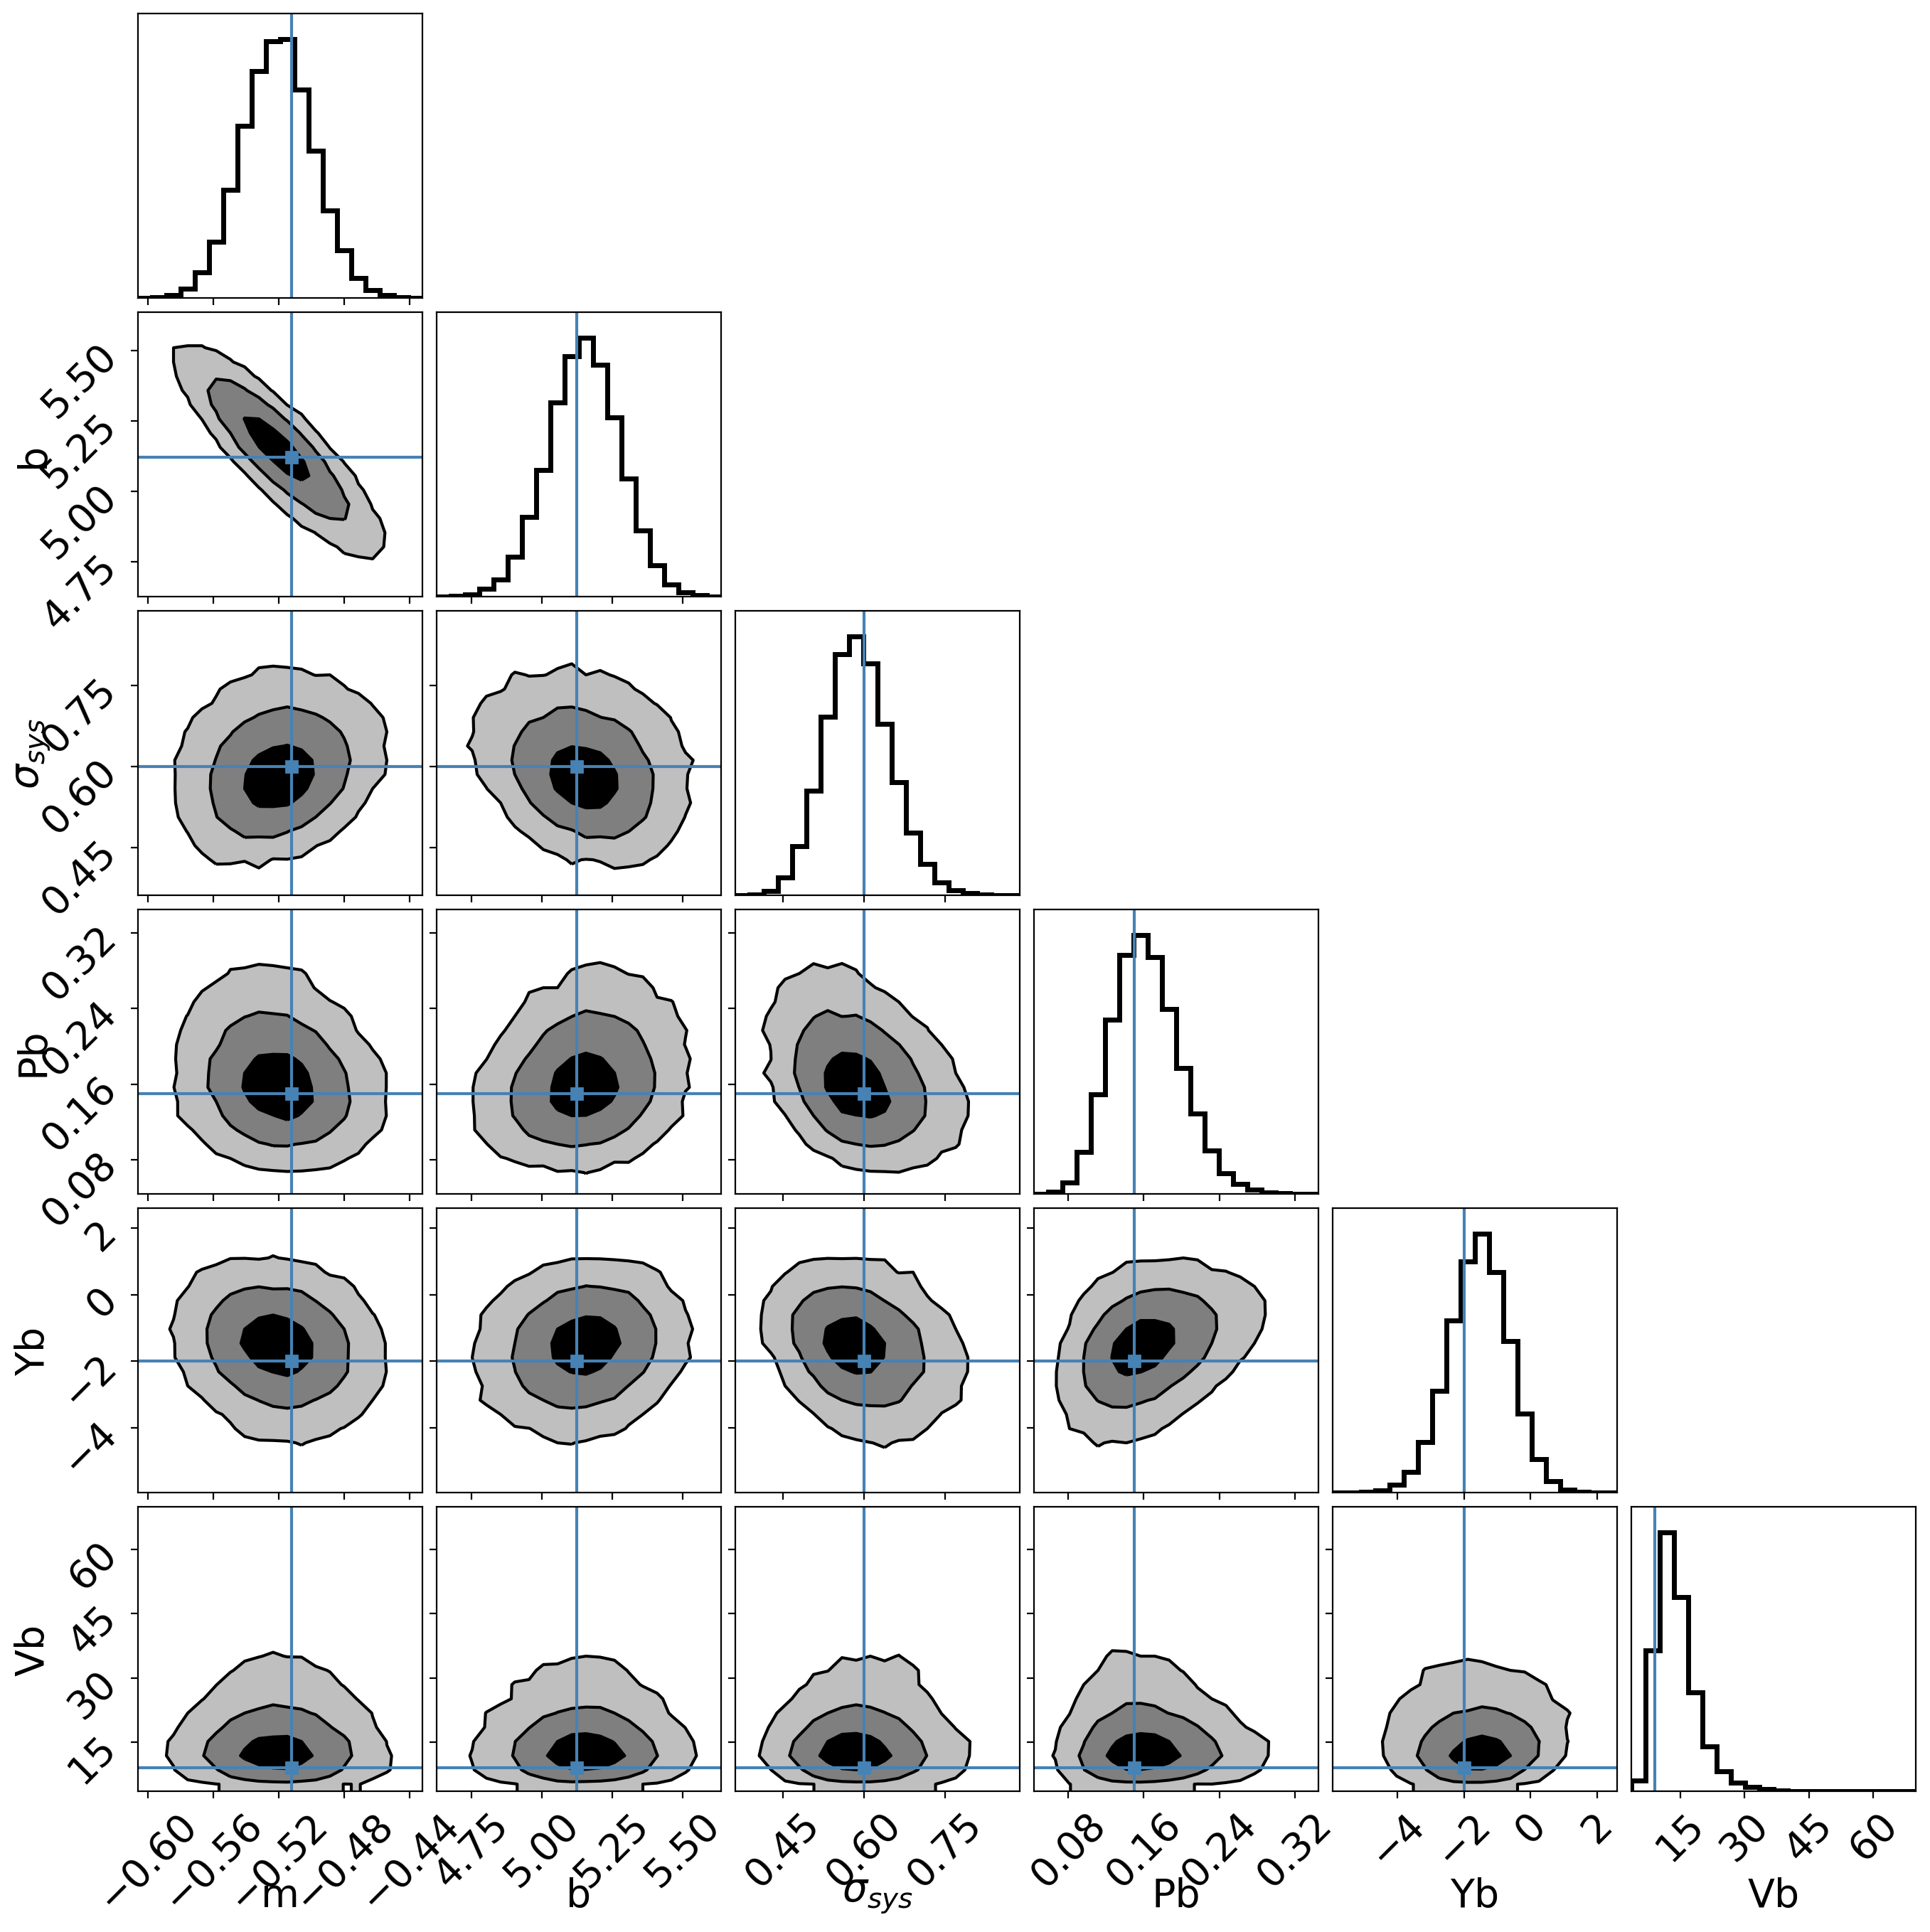

In [24]:
## make a corner plot.
import corner

fig = corner.corner( 
    flat_samples, labels=labels, truths=[m_true, b_true, sigsys_true, pb_true, yb_true, vb_true],
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.4f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

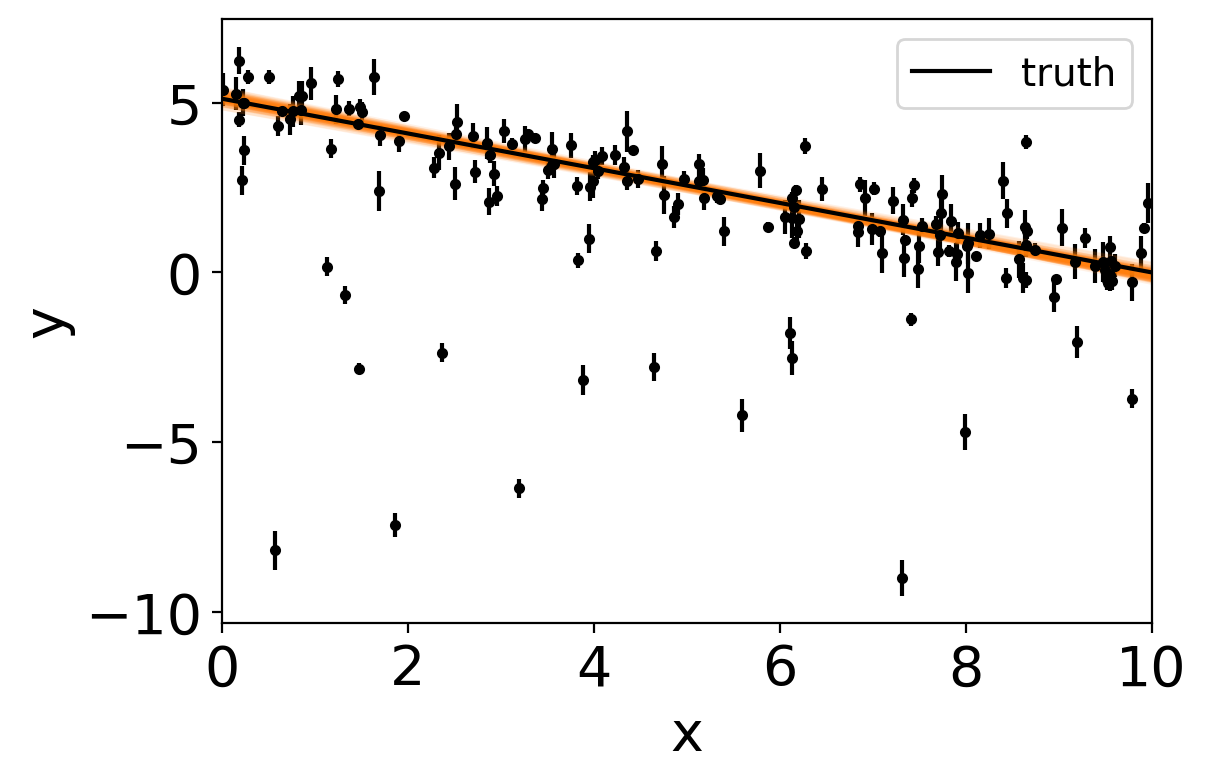

In [25]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Report the numbers:

In [26]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note that although the returned parameters are reasonable compared to the input, Yb and Vb are very poorly constrained. This makes some sense though, since there aren't many outliers. Ironically, if we had MORE outliers, it might be easier to model this distribution. However, I ran tests above (increasing Pb) and decided this was a very bad idea:<br>
<b>Large values of Pb make it hard to reproduce m, b, and $\sigma_{sys}$ consistently</b><br>
Instead, I suggest limiting Pb in advance via physically motivated methods (e.g., cutting out clear junk).<br><br>


It should be possible to find out which stars are outliers based on the probabilities:

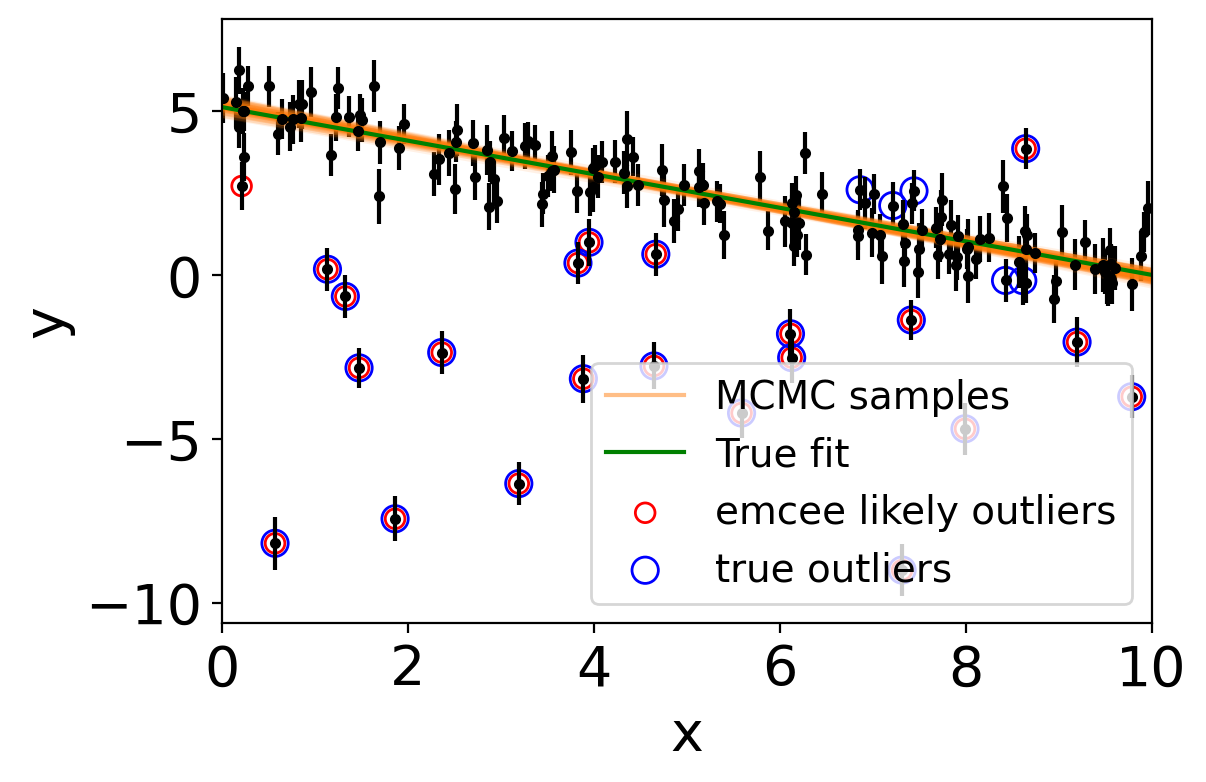

In [31]:
## identify the FPs

## first, take out the fit parameters. Note I'm lazily using median=best-fit, which is fine for 
## such a simple relation, but not necessarily OK generally. To get the best fit, use the likelihood
## values from the MCMC chain (check emcee docs).
params = np.array([0.,0.,0.,0.,0.,0.])
for i in range(ndim):
    params[i] = np.percentile(flat_samples[:, i],[50])

norm = 0.0
post_prob = np.zeros(len(x))
#for i in range(len(x)):
m, b, sig, Pb, Yb, Vb = params
model = m * x + b
sigma2 = yerr ** 2 + sig**2
p_fg = ((1-Pb) / np.sqrt(2 * np.pi * sigma2)) * np.exp(-(y-model)**2/(2 * sigma2))
p_bg = (Pb / np.sqrt(2 * np.pi * (Vb + sigma2))) * np.exp(-(y - Yb)**2/(2 * (Vb + sigma2)))

## p_fg and p_bg are the probabilities of being in the foreground (main) and background (outlier) distributions
## note that pb is included, because pb is actiling like a prior; the Gaussian distribution is the likelihood and
## pb is the prior probability when applying Bayes theorem. There is a chance I am missing a normalization constant,
## but I think this is OK, because the normalization constant for both distributions should be the same i.e.,
## it would just force the sum of all probs to be 1. 
## Check there first if something is odd. 

## Likely outliers are where p_fg < p_bg. One could change this to only show 'high' probability outliers.
outliers = np.where(p_bg>p_fg)

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.plot(x0,np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.5,label='MCMC samples')
plt.errorbar(x, y, yerr=np.sqrt(yerr**2+params[2]**2), fmt=".k", capsize=0)
#plt.plot(x[outliers],y[outliers],'bo',color='blue',markersize=30)
plt.scatter(x[outliers],y[outliers], s=50, facecolors='none', edgecolors='r',label='emcee likely outliers')
plt.scatter(x[N:N+N_outliers+1],y[N:N+N_outliers+1], s=90, facecolors='none', edgecolors='blue',label='true outliers')
plt.plot(x0, m_true * x0 + b_true, "k", label="True fit",color='green')
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

So the red circles are the ones where the probability of being an outlier is higher than that of being in the main distribution. Blue cirlces are the 'true' outliers we injected at the start (not usually known). <br>

I am happy with the output. The method:<br>
1) Caught most of the true outliers<br>
2) Assigned few or no real members as FPs<br>
2) Returned the correct slope, y-intercept, and missing uncertainty parameter<br>
3) Was not biased in the direction of the outliers (I put them mostly below the distribution to test this)<br>

I think this method works. 